# NLP - Lab 3

In [9]:
!pip install pyLDAvis

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import pyLDAvis
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irazzivin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/irazzivin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load prepocessed data and concatenate it

In [11]:
df1 = pd.read_json("lenta_dataset.json")
df1

,article_id,title,category,tags,text
0,https://lenta.ru/news/2022/01/18/thai_covid/,Таиланд увеличил срок карантина для зараженных...,travel/world,путешествие,управление общественный здравоохранение пхукет...
1,https://lenta.ru/news/2022/01/18/europe/,Россиянам раскрыли способ попасть в закрытые е...,travel/world,путешествие,эксперт туротрасль раскрыть российский путешес...
2,https://lenta.ru/news/2022/01/18/highway_to_hell/,Застрявшие на круизном лайнере пассажиры назва...,travel/world,путешествие,пассажир круизный лайнер вынудить провести ден...
3,https://lenta.ru/news/2022/01/18/dominicana/,Российские туристы попали в ДТП с автобусом в ...,travel/world,путешествие,доминикана экскурсионный автобус турист среди ...
4,https://lenta.ru/news/2022/01/18/dogs/,Британка пыталась спасти собак после извержени...,travel/world,путешествие,тонга спасатель обнаружить тело летний британк...
...,...,...,...,...,...
5056,https://lenta.ru/news/2018/09/12/memes/,Интернету предрекли глобальную катастрофу,media/memes,интернет сми,европейский парламент утвердить новый закон ав...
5057,https://lenta.ru/news/2018/09/11/poyasnil/,Пользователь решил объяснить мемы в интернете ...,media/memes,интернет сми,сеть набирать популярность страница пользовате...
5058,https://lenta.ru/news/2018/09/11/zolotov_memes/,Дуэль главы Росгвардии и Навального окрестили ...,media/memes,интернет сми,пользователь сеть живо отреагировать заявление...
5059,https://lenta.ru/news/2018/09/11/serena/,Высмеявший истерику Серены Уильямс художник об...,media/memes,интернет сми,австралийский карикатурист марк найта mark kni...


In [12]:
df2 = pd.read_json("nnru_dataset.json")
df2

,article_id,title,category,tags,text
0,https://www.nn.ru/text/gorod/2022/03/27/70535720/,Нижегородец продает на «Авито» бигмак по цене ...,transport,"[«Авито», «индекс Биг Мака», странные товары с...",Жители Нижегородской области могут приобрести ...
1,https://www.nn.ru/text/transport/2022/03/27/70...,Часть улиц Студеная и Максима Горького в Нижне...,transport,"[Нижний Новгород, метро, перекрытие движения]",Рабочие перекрыли участки улиц Студеная и Макс...
2,https://www.nn.ru/text/house/2022/03/27/70532957/,"14 ошибок при стирке, которые обходятся вам сл...",transport,"[лайфхаки, стиральная машинка, уборка, стирка]","Вот уж кому было несладко, так это нашим бабуш..."
3,https://www.nn.ru/text/education/2022/03/27/70...,Новый сезон битвы молодых ученых Science Slam ...,transport,"[Science Slam, ННГУ им. Лобачевского, наука]",Открыт прием заявок на участие в битве молодых...
4,https://www.nn.ru/text/entertainment/2022/03/2...,«На лавочке семечки щелкать — не для меня»: ка...,transport,"[pole dance, таксистка, танцы на пилоне]","Днем Евгения Лоскутова крутит руль иномарки, а..."
...,...,...,...,...,...
3995,https://www.nn.ru/text/health/2022/02/08/70428...,«Поликлиники превращаются в рассадники инфекци...,incidents,"[коронавирус, Алексей Кокунин, омикрон]",За неделю в Нижегородской области суточный при...
3996,https://www.nn.ru/text/health/2022/02/07/70429...,В Нижнем Новгороде начали оформлять больничные...,incidents,"[больничный, коронавирус]",С сегодняшнего дня нижегородцы смогут открыть...
3997,https://www.nn.ru/text/health/2022/02/07/70428...,Дистанта не будет. Оперштаб пока не собирается...,incidents,"[Нижний Новгород, оперштаб по борьбе с коронав...",Оперативный штаб по коронавирусу решил пока не...
3998,https://www.nn.ru/text/gorod/2022/02/07/70428146/,Выпуск программы «Непутевые заметки» сняли в Н...,incidents,"[«Непутевые заметки», Нижний Новгород]",Выпуск программы «Непутевые заметки» сняли в Н...


In [24]:
#df3 = pd.read_json("meduza_dataset.json")
#df3

In [13]:
# concatenate all the datasets
df = df1.append(df2, ignore_index = True)
# tokenize words
texts = []
for i in range(df.shape[0]):
    texts.append(df['text'][i].split())



Собираем list всех уникальных категорий

In [14]:
categories_w_sub = df.category.unique() # categories with sub categories (e. g. )
categories = categories_w_sub.copy()
for i in range(len(categories)):
    categories[i] = re.sub(r'/.*',"", categories[i])
categories = np.unique(categories)
categories = np.delete(categories, np.where(categories == 'mir')) # we remove mir since mir and world are the same category
categories

array(['auto', 'health', 'incidents', 'media', 'science', 'sport',
       'style', 'transport', 'travel', 'world'], dtype=object)

###  Вычисление bigrams и добавление к каждому тексту

In [15]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

###  Формирование словаря и удаление слов выбросов

In [16]:
from gensim.corpora import Dictionary
dictionary = Dictionary(texts)
print(f"Dictionary length before filtering {len(dictionary)}")

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

print(f"Dictionary length after filtering {len(dictionary)}")

Dictionary length before filtering 140296
Dictionary length after filtering 19829


In [17]:
temp = dictionary[0]  # This is only to "load" the dictionary.
#dictionary.id2token

###  Векторизация текста

In [18]:
corpus = [dictionary.doc2bow(text) for text in texts]
print(f"The total number of texts is {len(corpus)}")

The total number of texts is 9061


### Train LDA model

часть подготовительных фун-ций

In [19]:
def print_coherence(model, texts, dictionary):
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('Coherence Score:', coherence_score)

In [20]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def plot_worldclouds(lda_model, ncols, nrows):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    
    cloud = WordCloud(#stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      #colormap='tab10',
                      #color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False, num_topics=100)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < len(topics): # list index out of range fix 
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
            plt.gca().axis('off')

        else:
            fig.delaxes(ax) # when there are more subplots then topics, we just remove the extra subplots
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()  

Собираем list всех уникальных категорий в исследуемом датасете

In [21]:
categories, categories.shape

(array(['auto', 'health', 'incidents', 'media', 'science', 'sport',
        'style', 'transport', 'travel', 'world'], dtype=object),
 (10,))

Тк получилилось 10 уникальных категорий, соответственно кол-во топиков в LDA model так же определено 10 

In [43]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10 # number of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)


Визуализация топиков, которые сгенерировала модель

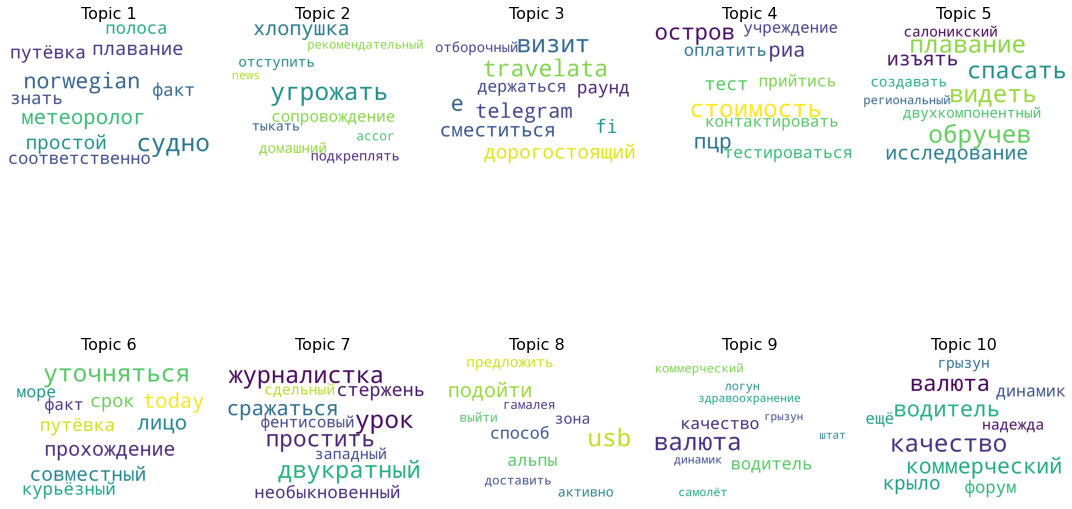

In [45]:
plot_worldclouds(model, 5, 3)

Подсчет Coherence score:

In [25]:
print_coherence(model=model, texts=texts, dictionary=dictionary)

Coherence Score: 0.6110082791155205


Визуализация топиков

In [26]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

Можем наблюдать пересечение некоторых топиков. Например, наиболее заметно, что топик 13 полностью включает в себя 5'й, такая же ситауация и с 10'м который входит в 4'й. Помимо этого, серьезное наложение присутствует у топиков 1 - 6, и 13-8

Проверка модели с другими кол-вами топиков:

In [27]:
from gensim.models import LdaModel

# Set training parameters.
nums_topics = [9, 13, 17, 21, 25] # numbers of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

best_coherence = 0
for num_topics in nums_topics:
    print(f"Fitting for {num_topics} target topics")
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=43
    )
    
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_lda_model = model
    print(f"Coherence score {coherence_score}")
    

Fitting for 9 target topics
Coherence score 0.6577158523943176
Fitting for 13 target topics
Coherence score 0.6102149207402051
Fitting for 17 target topics
Coherence score 0.6403087571430508
Fitting for 21 target topics
Coherence score 0.6626811135318541
Fitting for 25 target topics
Coherence score 0.621702799118643


The best score was achieved for 21 target topics

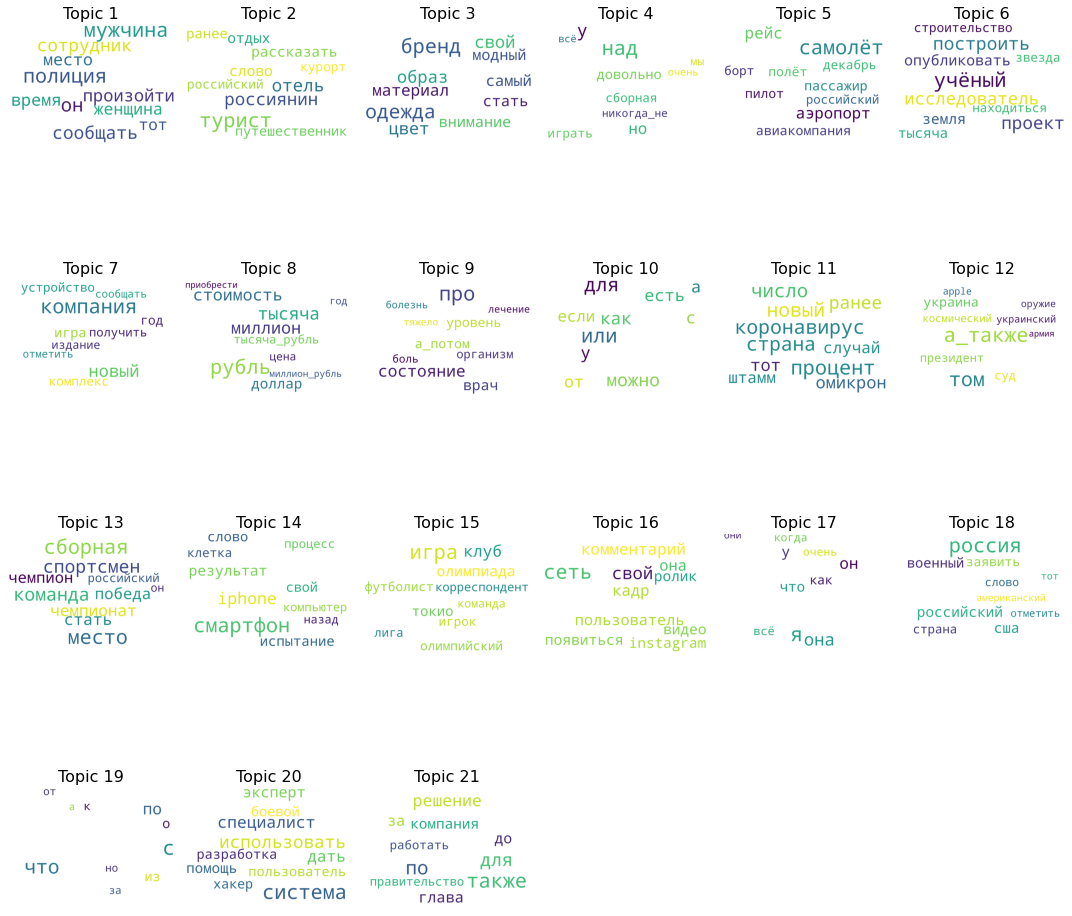

In [28]:
plot_worldclouds(best_lda_model, 6, 4)

In [29]:
lda_visualization = gensimvis.prepare(best_lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### Train LSI Model

In [30]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [31]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    #initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    #create Russian stop words list
    ru_stop = set(stopwords.words('russian'))
    ru_stop.update(['это', 'год', 'свой', 'который', 'ул', 'пгниу', 'мочь'])
    #Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    #list for tokenized documents in loop
    texts = []
    #loop through document list
    for i in doc_set:
        #clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        #remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in ru_stop]
        #stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        #add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    #Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    #Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

def create_gensim_lsi_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSI model using gensim
    Output : return LSI model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    
    #generate LSI model
    lsimodel = LsiModel(
        doc_term_matrix, 
        num_topics = number_of_topics, 
        id2word = dictionary,
        chunksize = 2000,
        power_iters = 3,
    )#train model
    
    #print(lsimodel.print_topics(num_topics = number_of_topics, num_words = words))
    return lsimodel
    
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSI topic models
              coherence_values : Coherence values corresponding to the LSI model with respective number of topics
    """
    coherence_values = list()
    model_list = []
    best_coherence = 0
    
    for num_topics in range(start, stop, step):
        #generate LSI model
        model = LsiModel(doc_term_matrix, num_topics = num_topics, id2word = dictionary)  #train model
        model_list.append(model)
        #calculate coherence_score
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        #choose best model
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_lsi_model = model
            
    return coherence_values, model_list, best_coherence, best_lsi_model

Так как мы имеем 10 уникальных категорий в исследуемом датасете, давайте построим визуализацию которая даст нам модель при значении 10 для параметра num_topics

In [47]:
#LSI Model
number_of_topics = 10
words = 10
document_list = df.text.tolist() #all texts
clean_text = preprocess_data(document_list)
dictionary, doc_term_matrix = prepare_corpus(clean_text)
model = create_gensim_lsi_model(clean_text, number_of_topics, words)
coherencemodel = CoherenceModel(model = model, texts = clean_text, dictionary = dictionary, coherence = 'c_v')
coherence_score = coherencemodel.get_coherence()
print("LSI coherence_score with 10 topics: ", coherence_score)

LSI coherence_score with 10 topics:  0.5408930862573706


In [48]:
topics = model.show_topics(formatted=False, num_topics=100)
for i in range (0, number_of_topics):
    lst = list()
    for item in topics[i][1]:
        lst.append(item[0])
    print("Topic", i)
    print(lst)

Topic 0
['россии', 'рф', 'украине', 'заявил', 'украины', 'сообщает', 'также', 'марта', 'новости', 'российских']
Topic 1
['н', 'новгород', 'г', 'автовокзал', 'щербинки', 'р', 'городец', 'автостанция', 'т', 'д']
Topic 2
['всё', 'рублей', 'очень', '1', 'рф', 'лет', 'которые', 'нужно', 'года', 'пока']
Topic 3
['области', 'россии', 'беженцев', 'ростовской', 'днр', 'украины', 'сообщает', 'лнр', 'марта', 'рф']
Topic 4
['сборной', 'шайбу', 'рублей', 'сборная', 'наши', 'зоне', 'нашей', 'шайба', 'ворот', 'россии']
Topic 5
['1', '5', 'рублей', 'силу', 'признать', 'утратившим', 'подпункт', 'области', 'всё', 'слова']
Topic 6
['беженцев', 'области', 'ростовской', '5', '1', 'россии', 'лнр', 'донбасса', 'рублей', 'украины']
Topic 7
['рублей', '5', 'тысяч', 'признать', 'силу', '1', 'утратившим', 'подпункт', 'слова', 'уроженец']
Topic 8
['россия', 'российский', 'ранее', 'стать', 'слово', 'новый', 'тысяча', 'страна', 'рублей', 'рубль']
Topic 9
['уроженец', 'района', 'сержант', 'старший', 'александр', 'се

Теперь построим график c зависимостью coherence_score от num_topics.

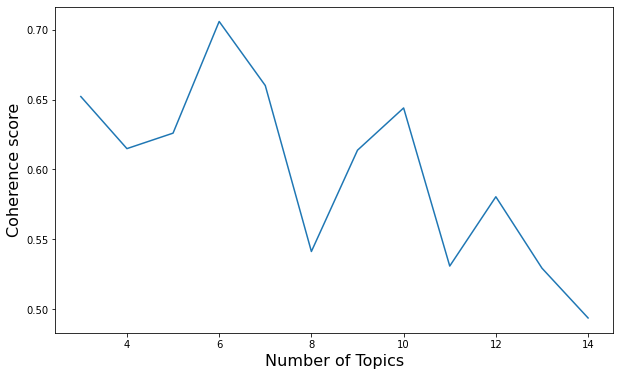

In [49]:
coherence_values, model_list, best_coherence, best_lsi_model = compute_coherence_values(
                                dictionary, doc_term_matrix, clean_text, stop=15, start=3, step=1)

num_topics = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.figure(figsize=(10, 6))
plt.plot(num_topics, coherence_values)
plt.xlabel("Number of Topics", fontsize = 16)
plt.ylabel("Coherence score",  fontsize = 16)
plt.show()

Как наглядно видно в таблицы наилучший coherence scor был получен для 3 target topics

In [53]:
print("Coherence score for 6 target topics: ", best_coherence)

Coherence score for 6 target topics:  0.7059364393894322


In [54]:
def plot_cloud(lst):
    unique_string=(" ").join(lst)
    wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(4,4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

Topic 0


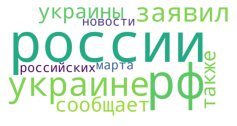

Topic 1


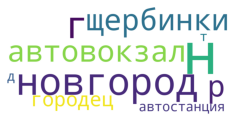

Topic 2


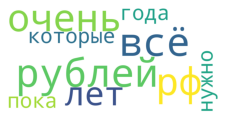

Topic 3


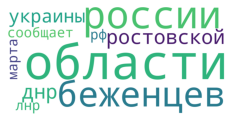

Topic 4


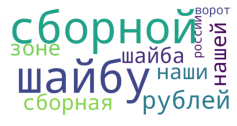

Topic 5


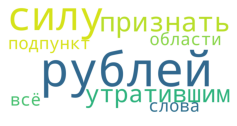

In [56]:
topics = best_lsi_model.show_topics(formatted=False, num_topics=100)
for i in range (0, 6):
    lst = list()
    for item in topics[i][1]:
        lst.append(item[0])
    print("Topic", i)
    plot_cloud(lst)


Так же была попытка обучения модели PLSA, но уперся в ее ограничение в 1000 текстов

## HDP model

In [38]:
from gensim.models import HdpModel
from gensim.models.coherencemodel import CoherenceModel

In [39]:
chunksize = 4000 # number documents that are processed at a time in the training algorithm

# Make a index to word dictionary.
id2word = dictionary.id2token

model = HdpModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,

    random_state=42
)

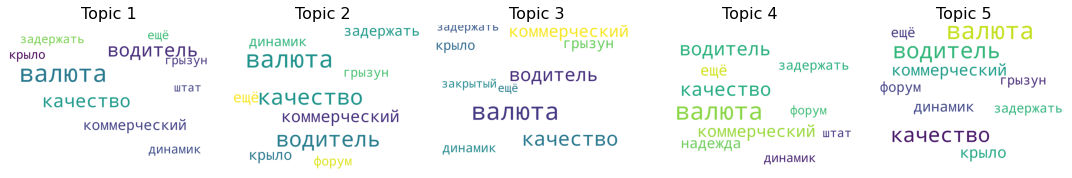

In [40]:
plot_worldclouds(model, 5, 1)


Полученные группы выглядят схоже, так как содержат одинаковые слова, такие как «валюта», «качество», «водитель» и т. д.

In [57]:
coherencemodel = CoherenceModel(model = model, texts =texts, dictionary = dictionary, coherence = 'c_v')
coherence_score = coherencemodel.get_coherence()
print('HDP coherence score: ' , coherence_score)

HDP coherence score:  nan


In [58]:
coherence_score

nan

Подытоживая, лучшие показатели coherence scores, которые были достигнуты:</br>
1. LDA model - 0.66
2. LSI model - 0.70
3. HDP model - 0.65

Хоть наилучшего результата удалось добиться с моделью LSI, «облака» топиков этой модели выглядят странными, и они мало чем отличаются друг от друга. В заключении можно сделать вывод что coherance metric не во всех случаях является лучшим подходом к оценки topic modeling.